# Merging Datasets to fill in **Address** Feature.

Previous **no_dupe_df.csv** has 813 addresses listed as "No primary address specified".

**[Data Dictionary](https://data.wprdc.org/dataset/condemned-properties/resource/0a963f26-eb4b-4325-bbbc-3ddf6a871410)** lists that the missing street address could be found in the [Allegheny County Property Assessments table](https://data.wprdc.org/dataset/property-assessments), which we will combine to see.

With 460 of the properties (condemned and dead-end) being owned by the City of Pittsburgh, we can also combine it with the [City-Owned Properties](https://data.wprdc.org/dataset/city-owned-properties/resource/e1dcee82-9179-4306-8167-5891915b62a7) dataset.

### **Datasets Needed (Allegheny):**

- **no_dupe_df.csv** (our data from EDA/Data Cleaning)
- **property assessment parcel data.csv**(Allegheny County Property Assessments Table)


The property assessment data is a large file.

# **Bring in our original dataset**


In [4]:
# importing libraries
import pandas as pd               # data preprocessing
import numpy as np                # to work with #'s & arrays
import matplotlib.pyplot as plt   # more for graphing/visualizations

In [5]:
our_data = "no_dupe_df.csv"
df = pd.read_csv(our_data)
df.head(2)

,_id,parcel_id,address,owner,property_type,latest_inspection_result,inspection_status,new_date,new_time,score
0,332079,0001G00106000000,"108 MARKET ST, Pittsburgh, PA 15222",BOULEVARD & MARKET LLC,Condemned Property,Pass,Active,2023-11-29,00:00:00,1
1,332078,0001G00107000000,No primary address specified,TROY DEVELOPMENT ASSOCIATES LP,Condemned Property,Pass,Active,2023-11-29,00:00:00,1


# **Allegheny County Property Assessments**

**Clean Data** --> only rows matching the pid's of our dataset


In [6]:
# bring in the file
property_parcel = "property assessment parcel data.csv"
property_df = pd.read_csv(property_parcel)
property_df.head(3)                                         # sanity check - first 3

<ipython-input-6-1822772855>:3: DtypeWarning: Columns (20,21,30,31,32,39,47,58,84) have mixed types. Specify dtype option on import or set low_memory=False.
  property_df = pd.read_csv(property_parcel)


,_id,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYCITY,PROPERTYSTATE,PROPERTYUNIT,PROPERTYZIP,MUNICODE,...,HALFBATHS,HEATINGCOOLING,HEATINGCOOLINGDESC,FIREPLACES,BSMTGARAGE,FINISHEDLIVINGAREA,CARDNUMBER,ALT_ID,TAXYEAR,ASOFDATE
0,1,0001D00145000000,433.0,,MARKET ST,PITTSBURGH,PA,,15222.0,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,01-JUN-25
1,2,0001D00146000000,435.0,,MARKET ST,PITTSBURGH,PA,,15222.0,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,01-JUN-25
2,3,0001D00150000000,130.0,-160,5TH AVE,PITTSBURGH,PA,,15222.0,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,01-JUN-25


In [7]:
property_df.columns

Index(['_id', 'PARID', 'PROPERTYHOUSENUM', 'PROPERTYFRACTION',
       'PROPERTYADDRESS', 'PROPERTYCITY', 'PROPERTYSTATE', 'PROPERTYUNIT',
       'PROPERTYZIP', 'MUNICODE', 'MUNIDESC', 'SCHOOLCODE', 'SCHOOLDESC',
       'LEGAL1', 'LEGAL2', 'LEGAL3', 'NEIGHCODE', 'NEIGHDESC', 'TAXCODE',
       'TAXDESC', 'TAXSUBCODE', 'TAXSUBCODE_DESC', 'OWNERCODE', 'OWNERDESC',
       'CLASS', 'CLASSDESC', 'USECODE', 'USEDESC', 'LOTAREA', 'HOMESTEADFLAG',
       'FARMSTEADFLAG', 'CLEANGREEN', 'ABATEMENTFLAG', 'RECORDDATE',
       'SALEDATE', 'SALEPRICE', 'SALECODE', 'SALEDESC', 'DEEDBOOK', 'DEEDPAGE',
       'PREVSALEDATE', 'PREVSALEPRICE', 'PREVSALEDATE2', 'PREVSALEPRICE2',
       'CHANGENOTICEADDRESS1', 'CHANGENOTICEADDRESS2', 'CHANGENOTICEADDRESS3',
       'CHANGENOTICEADDRESS4', 'COUNTYBUILDING', 'COUNTYLAND', 'COUNTYTOTAL',
       'COUNTYEXEMPTBLDG', 'LOCALBUILDING', 'LOCALLAND', 'LOCALTOTAL',
       'FAIRMARKETBUILDING', 'FAIRMARKETLAND', 'FAIRMARKETTOTAL', 'STYLE',
       'STYLEDESC', 'STORIES', 

To-Do:
- keep: PARID, PROPERTYHOUSENUM, PROPERTYADDRESS, PROPERTYCITY, PROPERTYSTATE, PROPERTYZIP
- check for matching PARID == parcel_id
- check for '0' in PROPERTYHOUSENUM --> then keep it as "No primary address specified"
- concatenate the Property features together into 1 new Address Feature.

If 'PROPERTYHOUSENUM' is 0, the parcel no longer exists (from data info).

filter the property_df into rows that match the parcel_id from our orginal df.

In [8]:
# keep features I want from this new dataset
property_df = property_df[['PARID', 'PROPERTYHOUSENUM', 'PROPERTYADDRESS', 'PROPERTYCITY', 'PROPERTYSTATE', 'PROPERTYZIP']].copy()

# parcel ids I want from this dataset - match original data pids
pids = set(df['parcel_id'])

# only keep the row if it has same parcel_id
property_df = property_df[property_df['PARID'].isin(pids)]
print(len(property_df))       # check if it has all 2,802

2802


Now create a new feature "Address" by concatenating the property features.

In [9]:
'''Build Address:
    - If housenum = 0, no address
    - If not, combine the other features together
        converting house num and zip into integers before making it into an address.
'''
def build_address(row):
    num = row['PROPERTYHOUSENUM']
    # when housenum = 0
    if pd.isna(num) or num == 0:
        return "No primary address specified"
    # if not add all together
    return (
        f"{int(num)} {row['PROPERTYADDRESS'].strip()}, "
        f"{row['PROPERTYCITY'].strip()}, "
        f"{row['PROPERTYSTATE'].strip()} "
        f"{int(row['PROPERTYZIP'])}"
    )

# apply the function
property_df["Address"] = property_df.apply(build_address, axis = 1)

property_df.head(2) # print to check

,PARID,PROPERTYHOUSENUM,PROPERTYADDRESS,PROPERTYCITY,PROPERTYSTATE,PROPERTYZIP,Address
14,0001G00106000000,0.0,MARKET ST,PITTSBURGH,PA,15222.0,No primary address specified
15,0001G00107000000,100.0,MARKET ST,PITTSBURGH,PA,15222.0,"100 MARKET ST, PITTSBURGH, PA 15222"


In [10]:
# it worked, so drop the other columns
property_df.drop(columns=['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYSTATE','PROPERTYZIP'], inplace=True)
property_df.head(2) # check again

,PARID,Address
14,0001G00106000000,No primary address specified
15,0001G00107000000,"100 MARKET ST, PITTSBURGH, PA 15222"


Now we can merge.

In [11]:
# left join
merged_df = df.merge(property_df, how = 'left', left_on = 'parcel_id',
                     right_on = 'PARID') # drop PARID later after checking
merged_df.head(3) # check

,_id,parcel_id,address,owner,property_type,latest_inspection_result,inspection_status,new_date,new_time,score,PARID,Address
0,332079,0001G00106000000,"108 MARKET ST, Pittsburgh, PA 15222",BOULEVARD & MARKET LLC,Condemned Property,Pass,Active,2023-11-29,00:00:00,1,0001G00106000000,No primary address specified
1,332078,0001G00107000000,No primary address specified,TROY DEVELOPMENT ASSOCIATES LP,Condemned Property,Pass,Active,2023-11-29,00:00:00,1,0001G00107000000,"100 MARKET ST, PITTSBURGH, PA 15222"
2,332077,0001G00109000000,No primary address specified,TROY DEVELOPMENT ASSOCIATES LP,Condemned Property,Pass,Active,2023-11-29,00:00:00,1,0001G00109000000,"100 MARKET ST, PITTSBURGH, PA 15222"


In [12]:
merged_df.drop(columns = 'PARID', inplace = True)

This shows that some 'address' from df had a valid address when property_df did not, but property_df added valid addresses to 'Address' when original df did not.

Now we compare the 2 address columns and keep one.

In [13]:
'''Final Address:
    - If one has a valid address keep the valid address
    - If both are No addresses, it stays
'''
def final_add(dataframe):
    no_add = "No primary address specified"
    original = dataframe['address']     # our original address feature
    new = dataframe['Address']          # our new address feature

    if original == no_add and new != no_add:  # keep new address if it is valid
        return new
    return original                     # if not keep original (valid or no add)

# apply to our df
merged_df['final_address'] = merged_df.apply(final_add, axis=1)

# check to make sure it worked correctly
print(merged_df[['parcel_id','address','Address','final_address']].head())

          parcel_id                              address  \
0  0001G00106000000  108 MARKET ST, Pittsburgh, PA 15222   
1  0001G00107000000         No primary address specified   
2  0001G00109000000         No primary address specified   
3  0001H00046000000       209 1ST AVE, Pittsburgh, 15222   
4  0001H00216000000       5 MARKET SQ, Pittsburgh, 15222   

                               Address                        final_address  
0         No primary address specified  108 MARKET ST, Pittsburgh, PA 15222  
1  100 MARKET ST, PITTSBURGH, PA 15222  100 MARKET ST, PITTSBURGH, PA 15222  
2  100 MARKET ST, PITTSBURGH, PA 15222  100 MARKET ST, PITTSBURGH, PA 15222  
3         No primary address specified       209 1ST AVE, Pittsburgh, 15222  
4    5 MARKET SQ, PITTSBURGH, PA 15222       5 MARKET SQ, Pittsburgh, 15222  


In [14]:
# then remove redundant features
merged_df.drop(columns=['address','Address'], inplace=True)

It worked properly. It seems like it has some repetitive addresses now. Let's check how many are repeated and how many still have no primary addresses.

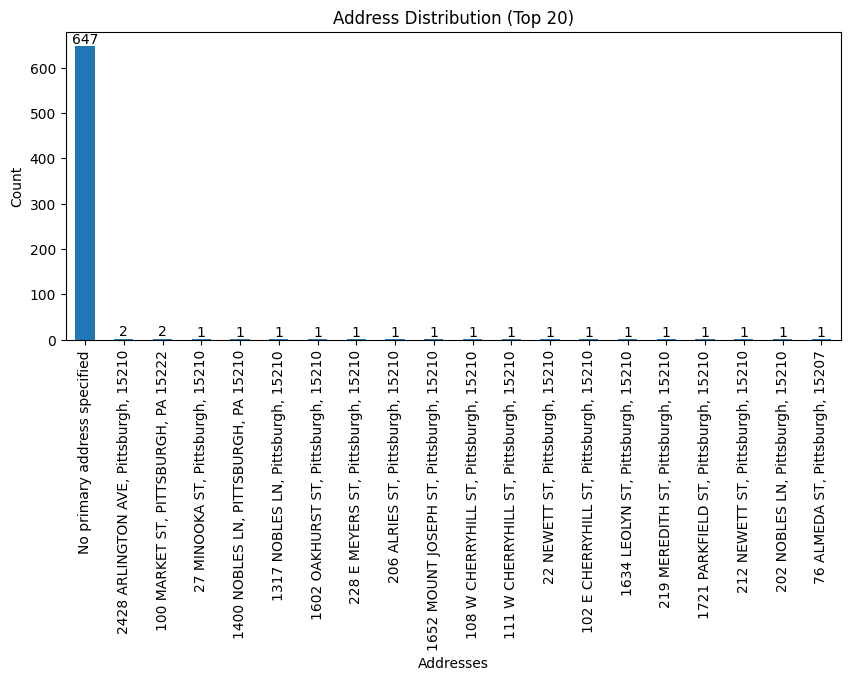

In [15]:
# address counts
add_counts = merged_df['final_address'].value_counts().nlargest(20)
# plot and label bars
add_graph = add_counts.plot(kind='bar', figsize=(10,4))
add_graph.bar_label(add_graph.containers[0])        # add the count labels
# design / details
plt.title('Address Distribution (Top 20)')
plt.xlabel("Addresses")
plt.ylabel('Count')
plt.show()

We have reduced No Address values from 813 to 647. Check how many of these belong to the **City of Pittsburgh**

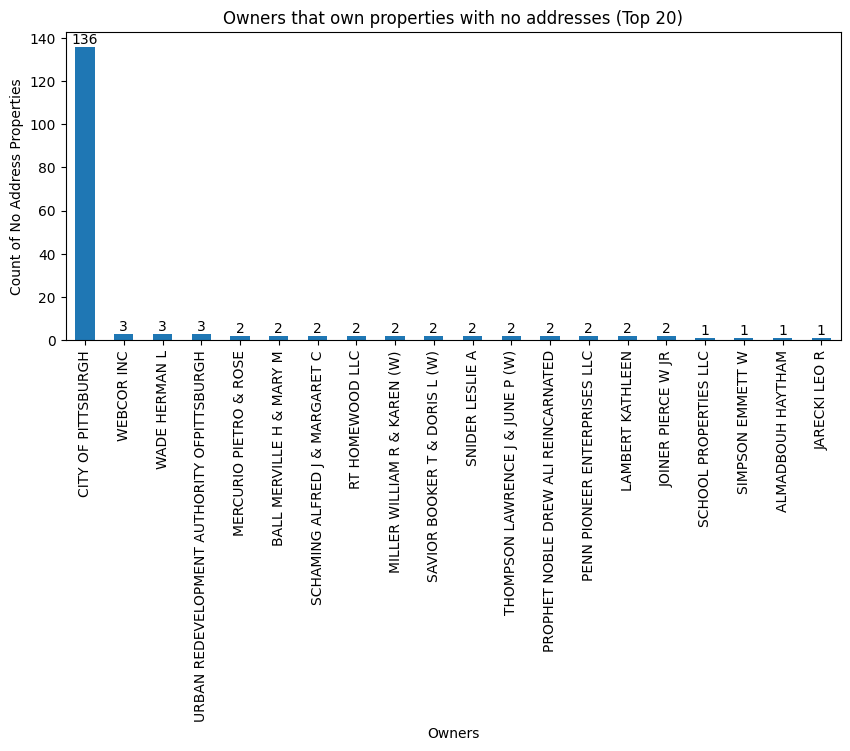

In [16]:
# create new df with just no address values
no_add = "No primary address specified"
no_address_df = merged_df[merged_df['final_address'] == no_add].copy()

# owner counts in no address df
owners_count = no_address_df['owner'].value_counts().nlargest(20)
# plot and label bars
no_add_owner_graph = owners_count.plot(kind='bar', figsize=(10,4))
no_add_owner_graph.bar_label(no_add_owner_graph.containers[0])              # add the count labels
# design / details
plt.title('Owners that own properties with no addresses (Top 20)')
plt.xlabel("Owners")
plt.ylabel('Count of No Address Properties')
plt.show()

City of Pittsburgh owns approximately 21% (136 properties) of properties that do not have an address attached to it.

**Save merged_df.csv** --> saved to keep the data with address from original data + Allegheny addresses



In [17]:
merged_df.to_csv('merged_df.csv', index = False)

### **Insights**

- **merged_df** is our original data from after merging with the allegheny dataset
- Reduced No Address values from 813 to 647.


**alleghney_2802.csv** saved for data related to our parcel_id in condemned/dead-end properties dataset for reference.
- Features: ['PARID', 'Address']

In [20]:
property_df.to_csv('allegheny_2802.csv', index = False)